# Advanced Land Finding Implementation

#### Imports

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
%matplotlib qt

#### Helper functions

In [2]:
def draw_corner_image(img, patternSize=(9,6)):    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)    
    ret, corners = cv2.findChessboardCorners(gray, (patternSize[0],patternSize[1]), None)    
    if ret == True:
        return cv2.drawChessboardCorners(np.copy(img), (patternSize[0],patternSize[1]), corners, ret)

## Camera Calibration / Distortion Correction

To compensate the distortion caused by the camera lens, the class "CameraCalibrate" has been implemented. The Constructor parameter is a pattern for the file names of the calibration images. The class uses the OpenCV function "cv2.findChessboardCorners()" to find the corners in the calibration images and to use the "cv2.calibrateCamera()" function to calculate the camera matrix and the distortion coefficient. With the method "undistort_image" the distortion can be calculated out of the pictures.

In [3]:
class CameraCalibrate:
    __img_size = None # size of a calibration image
    
    __objpoints = [] # 3d points in real world space
    __imgpoints = [] # 2d points in image plane.
    
    __mtx = None
    __dist = None
    
    def __detect_image_and_object_points(self, path_pattern, pattern_size):
        # prepare object points
        objp = np.zeros((pattern_size[1]*pattern_size[0],3), np.float32)
        objp[:,:2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape(-1,2)
    
        # create list of all calibration images
        images = glob.glob(path_pattern)
              
        for idx, fname in enumerate(images):
            # load image
            img = cv2.imread(fname)
            
            # keep image size
            self.__img_size = (img.shape[1], img.shape[0]) 
        
            # convert image to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
            # Find the chessboard corners        
            ret, corners = cv2.findChessboardCorners(gray, (pattern_size[0],pattern_size[1]), None)
        
            if ret == True:
                # add object and image points
                self.__objpoints.append(objp)
                self.__imgpoints.append(corners)        
        pass
    
    def undistort_image(self, image):
        return cv2.undistort(image, self.__mtx, self.__dist, None, self.__mtx)
    
    def __init__(self, path_pattern, pattern_size=(9,6)):
        # detect image and object points
        self.__detect_image_and_object_points(path_pattern, pattern_size)

        # Do camera calibration given object points and image points
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(self.__objpoints, self.__imgpoints, self.__img_size, None, None)
        
        # store camera matrix and distortion coeffs
        self.__mtx = mtx
        self.__dist = dist
        pass                                  

In [4]:
# Instantiate the CameraCalibrate Class 
camera_calibrate = CameraCalibrate('camera_cal/calibration*.jpg')

Here are 3 sample images to see.<br />
Picture 1 shows the original picture.<br />
Picture 2 the detected corners visualized with the method "cv2.drawChessboardCorners ()"<br />
Picture 3 the undistorted result picture.

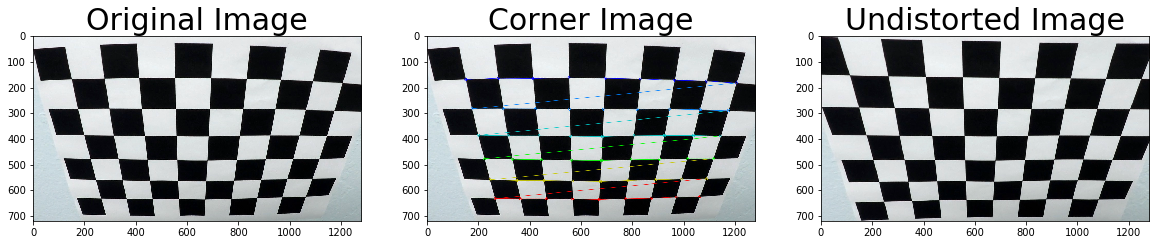

In [5]:
# Load a sample Calibration image
calibration_image = cv2.imread('camera_cal/calibration2.jpg')
cv2.imwrite('output_images/calibration_orignal_image.jpg',calibration_image)

# detect and draw chessboard corners
corner_img = draw_corner_image(calibration_image)
cv2.imwrite('output_images/calibration_corner_image.jpg',corner_img)

# undistort image using the CameraCalibrate class
undistort_image = camera_calibrate.undistort_image(calibration_image)
cv2.imwrite('output_images/calibration_undist_image.jpg',corner_img)

# plot sample images
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(calibration_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(corner_img)
ax2.set_title('Corner Image', fontsize=30)
ax3.imshow(undistort_image)
ax3.set_title('Undistorted Image', fontsize=30)


## Color and Gradient Threshold

In the class "ColorGradientFilter" several operations are performed on the undistorted image to highlight the lane lines. First, a Sobel edge detection is performed on the image. Subsequently, using thresholds to filter the color of the lanes on HLS and RGB image.
The individual images are then combined into a complete picture. Afterwards the "Region of Interest" will be cut out of the picture to discard unnecessary image information.

In [6]:
class ColorGradientFilter:
    
    def __filter_hls_channel(self, hls, channel, thresh=(0, 255)):        
        hls_channel = hls[:,:,channel]        
        return (hls_channel > thresh[0]) & (hls_channel <= thresh[1])       
    
    def __filter_r_and_g_channel(self, rgb, thresh=255):        
        R = rgb[:,:,0]
        G = rgb[:,:,1]
        return (R > thresh) & (G > thresh) 
            
    def __abs_sobel_thresh(self, image, orient='x', sobel_kernel=3, thresh=(0, 255)):
        # Take the derivative in x or y given orient = 'x' or 'y'
        if orient == 'x':
            sobel = cv2.Sobel(image, cv2.CV_64F, 1, 0)
        else:
            sobel = cv2.Sobel(image, cv2.CV_64F, 0, 1)

        # Take the absolute value of the derivative or gradient
        abs_sobel = np.absolute(sobel)

        # Scale to 8-bit (0 - 255) then convert to type = np.uint8
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

        # Create a mask of 1's where the scaled gradient magnitude 
        grad_binary = np.zeros_like(scaled_sobel)
        grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1            

        # Return this mask as your binary_output image
        return grad_binary

    def __mag_thresh(self, image, sobel_kernel=3, mag_thresh=(0, 255)):
        # Take the gradient in x and y separately
        sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0)
        sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1)

        # Calculate the magnitude 
        gradmag = np.sqrt(sobelx**2 + sobely**2)

        # Scale to 8-bit (0 - 255) and convert to type = np.uint8
        scale_factor = np.max(gradmag)/255 
        gradmag = (gradmag/scale_factor).astype(np.uint8) 

        # Create a binary mask where mag thresholds are met
        mag_binary = np.zeros_like(gradmag)
        mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

        # Return this mask as your binary_output image        
        return mag_binary

    def __dir_threshold(self, image, sobel_kernel=3, thresh=(0, np.pi/2)):
        # Take the gradient in x and y separately
        sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)    

        # Take the absolute value of the x and y gradients
        abs_sobelx = np.absolute(sobelx)
        abs_sobely = np.absolute(sobely)

        # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
        absgraddir = np.arctan2(abs_sobely, abs_sobelx)

        # Create a binary mask where direction thresholds are met
        dir_binary = np.zeros_like(absgraddir)
        dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

        # Return this mask as your binary_output image
        return dir_binary
 
    def pipeline(self, image):        
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        #clahe = cv2.createCLAHE()
        #gray = clahe.apply(gray)
        
        # sobel edge detection
        ksize = 3
        sx_binary = self.__abs_sobel_thresh(gray, 'x', sobel_kernel=ksize, thresh=(10, 200))
        dir_binary = self.__dir_threshold(gray, sobel_kernel=ksize, thresh=(np.pi/6, np.pi/2))
        combined_condition = ((sx_binary == 1) & (dir_binary == 1))

        
        # l channel and s threshold 
        hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        l_channel = self.__filter_hls_channel(hls, 1, thresh=(120, 255))
        s_channel = self.__filter_hls_channel(hls, 2, thresh=(100, 255))

        # r ang g threshold
        rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        color_combined = np.zeros_like(rgb[:,:,1])        
        r_g_channel = self.__filter_r_and_g_channel(rgb, 150)
        
        # combine thresholds
        color_combined = np.zeros_like(gray)
        color_combined[(r_g_channel & l_channel) & (s_channel | combined_condition)] = 1        
        
        # region of interest
        height, width = gray.shape
        mask = np.zeros_like(color_combined)
        region_of_interest = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
        cv2.fillPoly(mask, [region_of_interest], 1)
        thresholded = cv2.bitwise_and(color_combined, mask)
        
        return thresholded
    
    def __init__(self):
        pass

Here are 2 sample images:<br />
Picture 1: Shows the original picture.<br />
Figure 2: Shows the result image after the ColorGradFilter pipeline.

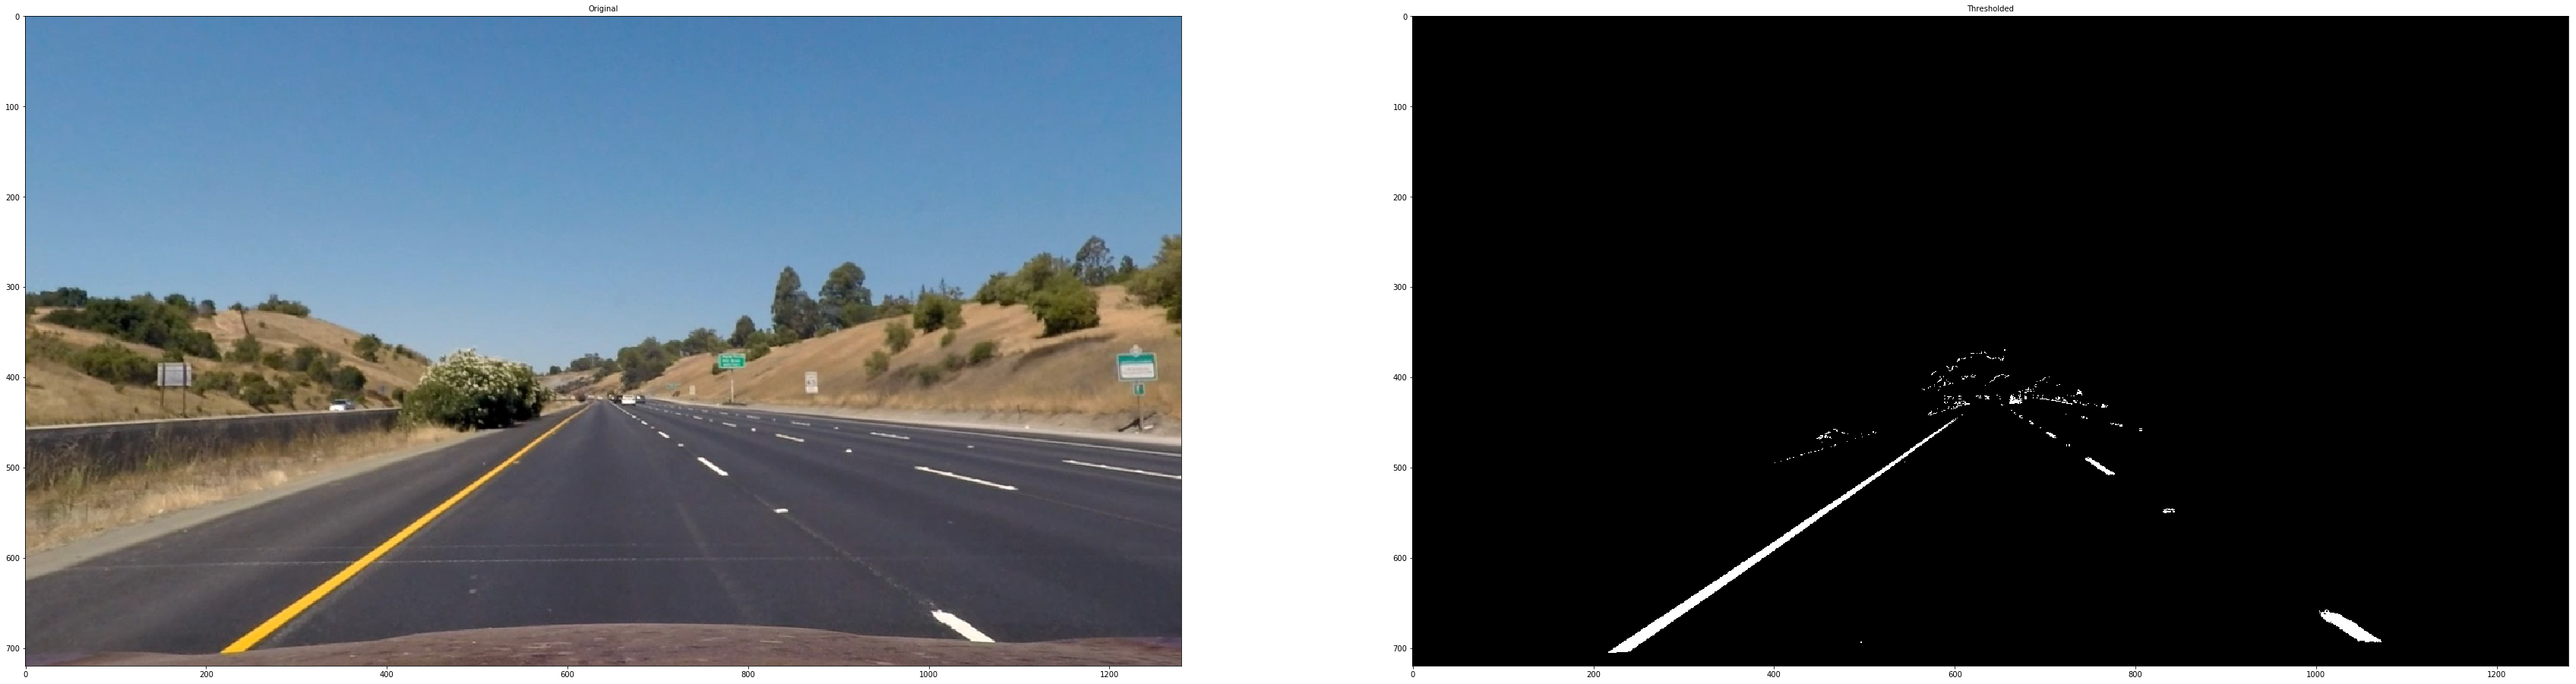

In [7]:
# initialize ColorGradientFilter
color_grad_filter = ColorGradientFilter()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(60,30))
img = camera_calibrate.undistort_image(cv2.imread('test_images/straight_lines1.jpg')) 
orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# execute filter pipeline
thresholded = color_grad_filter.pipeline(img)
    
# show sample images
ax1.imshow(orig_img, cmap="gray")
ax1.set_title('Original', fontsize=10)    
ax2.imshow(thresholded, cmap="gray")
ax2.set_title('Thresholded', fontsize=10)

# save sample images
f.savefig('output_images/thresholded_image.png')

## Transform Image to "bird's-eye view"

The Transform class is used to create a bird's-eye view image and inverse the bird's-eye view image back to the normal perspective.

In [8]:
class ImageTransformer:
    
    __src_trans = None
    __dst_trans = None
    
    def transform(self, image):
        img_size = (image.shape[1], image.shape[0])
        
        M = cv2.getPerspectiveTransform(self.__src_trans, self.__dst_trans)
        warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
        
        return warped
    
    def inv_transform(self, image):
        img_size = (image.shape[1], image.shape[0])
        
        M = cv2.getPerspectiveTransform(self.__dst_trans, self.__src_trans)
        warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
        
        return warped    
    
    def __init__(self, src_trans, dst_trans):
        self.__src_trans = src_trans
        self.__dst_trans = dst_trans
        pass    

In [9]:
src_trans = np.float32([[201,720],[1124,720],[561,474],[726,474]])
dst_trans = np.float32([[313,720],[994,720],[313,1],[994,1]])

# initialize the ImageTranfromer
image_transformer = ImageTransformer(src_trans, dst_trans)

Here are 2 sample images:<br />
Picture 1: Shows the original picture.<br />
Figure 2: Shows the result "bird's-eye view".

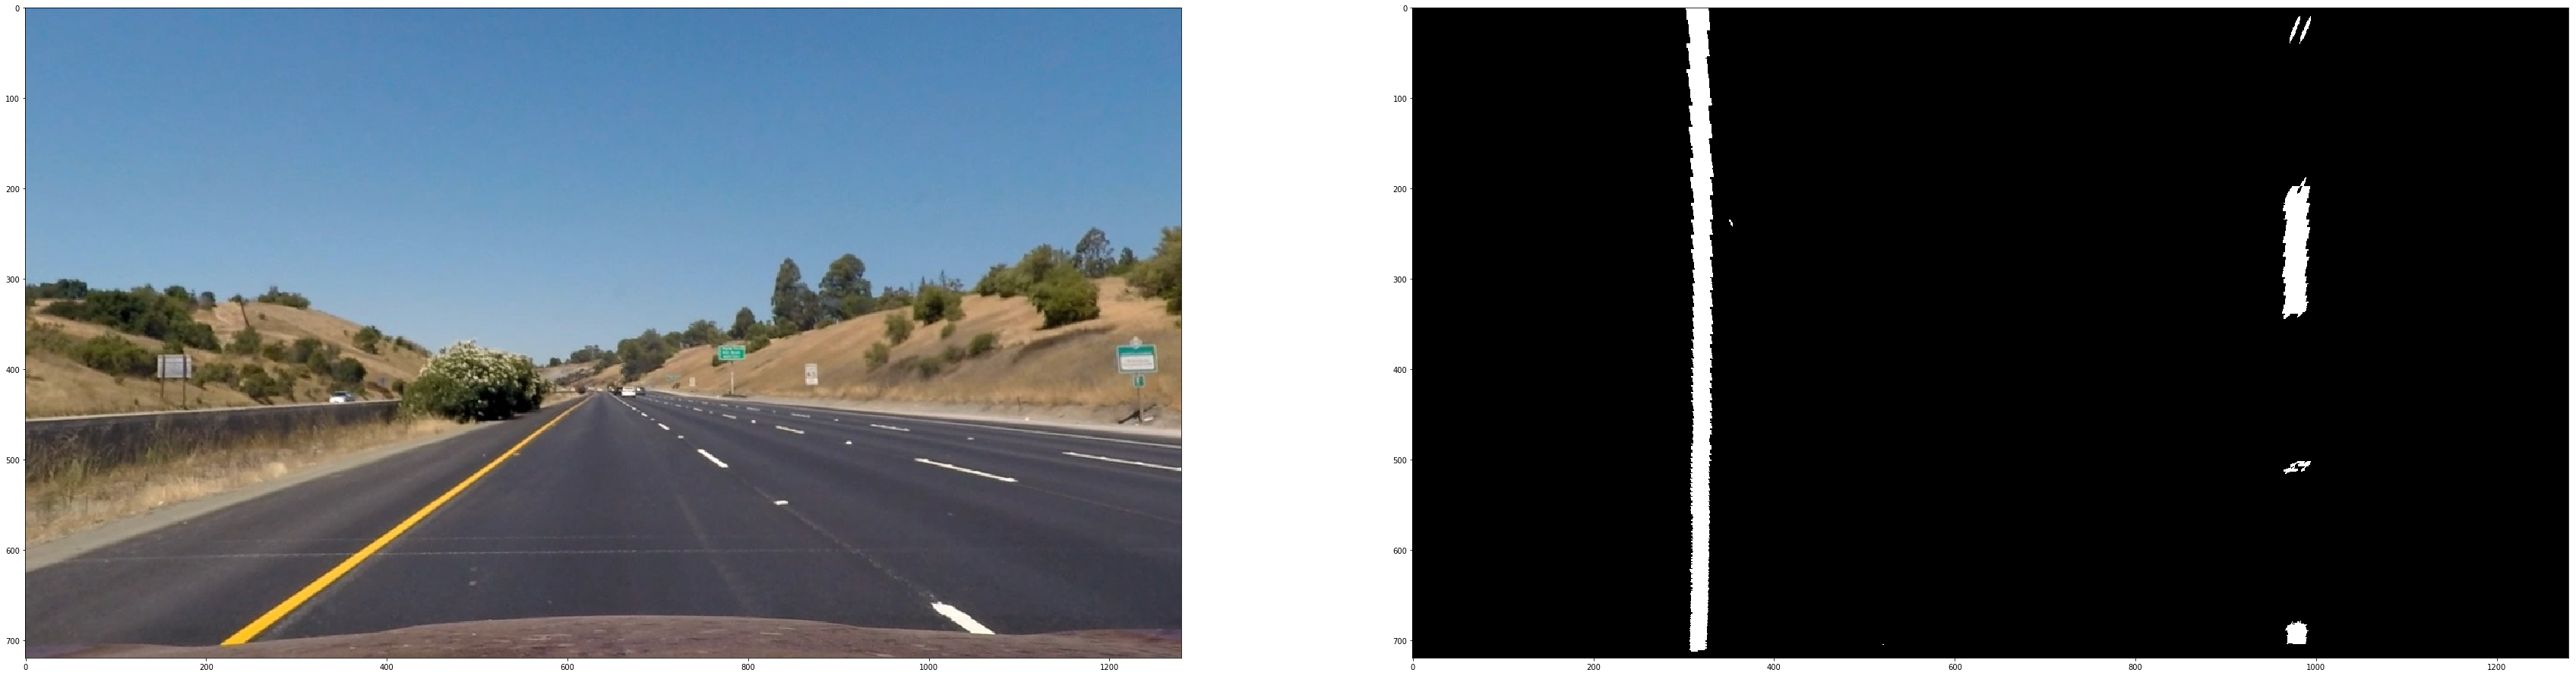

In [10]:
unwrapped = camera_calibrate.undistort_image(cv2.imread('test_images/straight_lines1.jpg'))
unwrapped = cv2.cvtColor(unwrapped, cv2.COLOR_BGR2RGB)

# execute transformation
warped = image_transformer.transform(thresholded)

# show sample images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(60,30))
ax1.imshow(unwrapped, cmap="gray")
ax2.imshow(warped, cmap="gray")

# save sample images
f.savefig('output_images/transformed_image.png')

## Histogram from transformed image

To detect the lanes in the image I use as histogram.<br />
The position of the peaks identifies the position of the lanes in the image.

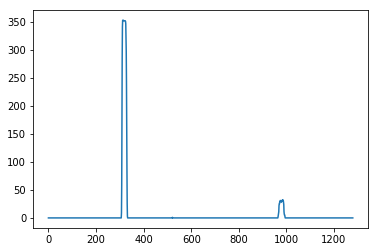

In [11]:
# create a copy to keep the original image
wrapped_cpy = np.copy(warped)

# create and show histogram
histogram = np.sum(wrapped_cpy[wrapped_cpy.shape[0]//2:,:], axis=0)

# show and store histogram
plt.plot(histogram)
plt.savefig('output_images/histogram.png')

## Implement LaneDetector

The LaneDetector implementation brings all steps together. <br />
The LaneDetector is initialized with instances of the CameraCalibrate, ColorGradientFilter and ImageTransformer class. In the pipeline, the distortion is first removed from the image. Subsequently, the highlighting of the lane markings is carried out via edge detection and color thresholds and then the image is transformed to the "bird's eye view".

After the transformation of the image, the lane recognition is performed on the image with the method "find_lanes ()". The method "find_lanes ()" contains 3 functions.<br />
1.) "Blind" search for the lane markings in the image<br />
2.) If lane markings have already been detected in the previous image, search the new lane markings at the last known position.<br />
3.) If no lane found at the last position, again a "blind search" is performed.

Based on the detected lanes, a calculation of the curvature radius and the vehicle offset to the middle of the road are executed.
The determined values are drawn to the image.

Finally, the area between the recognized lane lines is marked and an inverse transformation is performed on the image. This image combined with the original image results to the output image.

In [12]:
class LaneDetector:
    
    __camera_calibrator = None
    __image_filter = None
    
    __left_fit = None
    __right_fit = None
    
    __running_mean_difference_between_lines = 0
    __past_good_left_lines = []
    __past_good_right_lines = []
    
    def __line_predictions(self, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, image_height):
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Return None if no pixels found
        if(leftx.size == 0 or lefty.size == 0 or rightx.size == 0 or righty.size == 0):
            return None, None
        
        # Fit a second order polynomial to each
        self.__left_fit = np.polyfit(lefty, leftx, 2)
        self.__right_fit = np.polyfit(righty, rightx, 2)
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, image_height-1, image_height)
        
        leftx_prediction = self.__left_fit[0]*ploty**2 + self.__left_fit[1]*ploty + self.__left_fit[2]
        rightx_prediction = self.__right_fit[0]*ploty**2 + self.__right_fit[1]*ploty + self.__right_fit[2]        
    
        return leftx_prediction, rightx_prediction
    
    def __get_averaged_line(self, previous_lines, new_line):        
        num_frames = 12
    
        if new_line is None:            
            if len(previous_lines) == 0:
                # if no previous lines return None
                return previous_lines, None
            else:
                # return the last line
                return previous_lines, previous_lines[-1]
        else:
            if len(previous_lines) < num_frames:
                # we need at least num_frames frames to average over
                previous_lines.append(new_line)
                return previous_lines, new_line
            else:
                # average over the last num_frames frames
                previous_lines[0:num_frames-1] = previous_lines[1:]
                previous_lines[num_frames-1] = new_line
                new_line = np.zeros_like(new_line)
                for i in range(num_frames):
                    new_line += previous_lines[i]
                new_line /= num_frames
                return previous_lines, new_line
            
    def __measure_radius_of_curvature(self, x_values, image_height):
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        
        ploty = np.linspace(0, image_height-1, image_height)
        y_eval = np.max(ploty)
        fit_cr = np.polyfit(ploty*ym_per_pix, x_values*xm_per_pix, 2)
        curve_rad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
        return curve_rad
    
    def __search_on_last_fit(self, image):
        nonzero = image.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        
        left_lane_inds = ((nonzerox > (self.__left_fit[0]*(nonzeroy**2) + self.__left_fit[1]*nonzeroy + 
        self.__left_fit[2] - margin)) & (nonzerox < (self.__left_fit[0]*(nonzeroy**2) + 
        self.__left_fit[1]*nonzeroy + self.__left_fit[2] + margin))) 

        right_lane_inds = ((nonzerox > (self.__right_fit[0]*(nonzeroy**2) + self.__right_fit[1]*nonzeroy + 
        self.__right_fit[2] - margin)) & (nonzerox < (self.__right_fit[0]*(nonzeroy**2) + 
        self.__right_fit[1]*nonzeroy + self.__right_fit[2] + margin)))  
        
        left_x_predictions, right_x_predictions = self.__line_predictions(nonzerox, nonzeroy, left_lane_inds, right_lane_inds, image.shape[0])
        
        return left_x_predictions, right_x_predictions
    
    def __augmentImage(self, image, left_x_predictions, right_x_predictions):        
        ploty = np.linspace(0, image.shape[0]-1, image.shape[0])
        left_line_window = np.array(np.transpose(np.vstack([left_x_predictions, ploty])))
        right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_x_predictions, ploty]))))           
        poly_points = np.vstack([left_line_window, right_line_window])    
        cv2.fillPoly(image, np.int_([poly_points]), [0,255, 0])
        return image
    
    def sliding_windows_search(self, image):        
        # Assuming you have created a warped binary image called "image"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
        
        # store image height
        image_height = image.shape[0]
        
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((image, image, image))*255
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(image.shape[0]/nwindows)
        
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = image.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        
        # Set the width of the windows +/- margin
        margin = 100
        
        # Set minimum number of pixels found to recenter window
        minpix = 50
        
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = image.shape[0] - (window+1)*window_height
            win_y_high = image.shape[0] - window*window_height
            
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
           
        # Line prediction
        leftx_prediction, rightx_prediction = self.__line_predictions(nonzerox, nonzeroy, left_lane_inds, right_lane_inds, image_height)
       
        # Colorize ouput image
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
                
        return leftx_prediction, rightx_prediction, out_img
        
    def find_lanes(self, image):
        
        def check_mean_difference(mean_difference):
            return mean_difference < 0.7*self.__running_mean_difference_between_lines or mean_difference > 1.3*self.__running_mean_difference_between_lines
                
        image_height, image_width = (image.shape[0], image.shape[1])
        lanes_searched = False
        
        # create an output image
        out_img = np.dstack((image, image, image))*255
                
        # search per sliding windows search or on last known position        
        if((self.__left_fit is None) or (self.__right_fit is None)):
            # lanes in previous frame not found, search for lanes per sliding windows serach
            lanes_searched = True
            left_x_predictions, right_x_predictions, out_img = self.sliding_windows_search(image)        
        else:
            # lanes in previous frame found, search on last position + margin            
            left_x_predictions, right_x_predictions = self.__search_on_last_fit(image)
                
        # check lanes detected
        lanes_detected = (left_x_predictions is not None and right_x_predictions is not None)
        
        # if lanes detected check quality and search again if necessary
        if lanes_detected:            
            mean_difference = np.mean(right_x_predictions - left_x_predictions)
        
            if self.__running_mean_difference_between_lines == 0:
                self.__running_mean_difference_between_lines = mean_difference
        
            # check quality of lane detection
            if (check_mean_difference(mean_difference)):
                lanes_detected = False
                
                # if lane seach is not executed, try sliding windows search
                if not lanes_searched:
                    left_x_predictions, right_x_predictions, out_img = self.sliding_windows_search(image)
                    
                    # if lanes detected, check quality again
                    if (left_x_predictions is not None and right_x_predictions is not None):
                        mean_difference = np.mean(right_x_predictions - left_x_predictions)
                        lanes_detected = not check_mean_difference(mean_difference)                        
           
        
        if not lanes_detected:            
            self.__left_fit = None
            self.__right_fit = None
            if len(self.__past_good_left_lines) == 0 and len(self.__past_good_right_lines) == 0:
                return image
            else:
                left_x_predictions = self.__past_good_left_lines[-1]
                right_x_predictions = self.__past_good_right_lines[-1]
        else:
            self.__past_good_left_lines, left_x_predictions = self.__get_averaged_line(self.__past_good_left_lines, left_x_predictions)
            self.__past_good_right_lines, right_x_predictions = self.__get_averaged_line(self.__past_good_right_lines, right_x_predictions)
            mean_difference = np.mean(right_x_predictions - left_x_predictions)
            self.__running_mean_difference_between_lines = 0.9*self.__running_mean_difference_between_lines + 0.1*mean_difference
  
        # draw on output image
        out_img = self.__augmentImage(out_img, left_x_predictions, right_x_predictions)

        # compute the radius of curvature
        left_curve_rad = self.__measure_radius_of_curvature(left_x_predictions, image_height)
        right_curve_rad = self.__measure_radius_of_curvature(right_x_predictions, image_height)
        average_curve_rad = (left_curve_rad + right_curve_rad)/2
        
        # compute the offset from the center
        lane_center = (right_x_predictions[image_height-1] + left_x_predictions[image_height-1])/2
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        center_offset_pixels = abs(image_width/2 - lane_center)
        center_offset_mtrs = xm_per_pix*center_offset_pixels        
        
        return out_img, average_curve_rad, center_offset_mtrs
    
    def pipeline(self, image):
        # undistort image
        undist = self.__camera_calibrator.undistort_image(image)
        
        # color and gradient threshold
        thresholded = self.__image_filter.pipeline(undist)
        
        # transform image
        transformed = self.__transformer.transform(thresholded)
        
        # search for lanes
        out_img, average_curve_rad, center_offset_mtrs = self.find_lanes(transformed)
            
        # invert transformation
        inv_transformed = self.__transformer.inv_transform(out_img)
        
        # combine images
        result = cv2.addWeighted(image, 1, inv_transformed, 0.3, 0)
        
        # add text
        curvature_string = "Curvature radius: %.2f m" % average_curve_rad
        offset_string = "Center offset: %.2f m" % center_offset_mtrs
        
        cv2.putText(result, curvature_string , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
        cv2.putText(result, offset_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)           
         
        return result
    
    def __init__(self, camera_calibrator, image_filter, transformer):
        self.__camera_calibrator = camera_calibrator
        self.__image_filter = image_filter
        self.__transformer = transformer
        pass

### Show Sample Image from sliding windows search

True

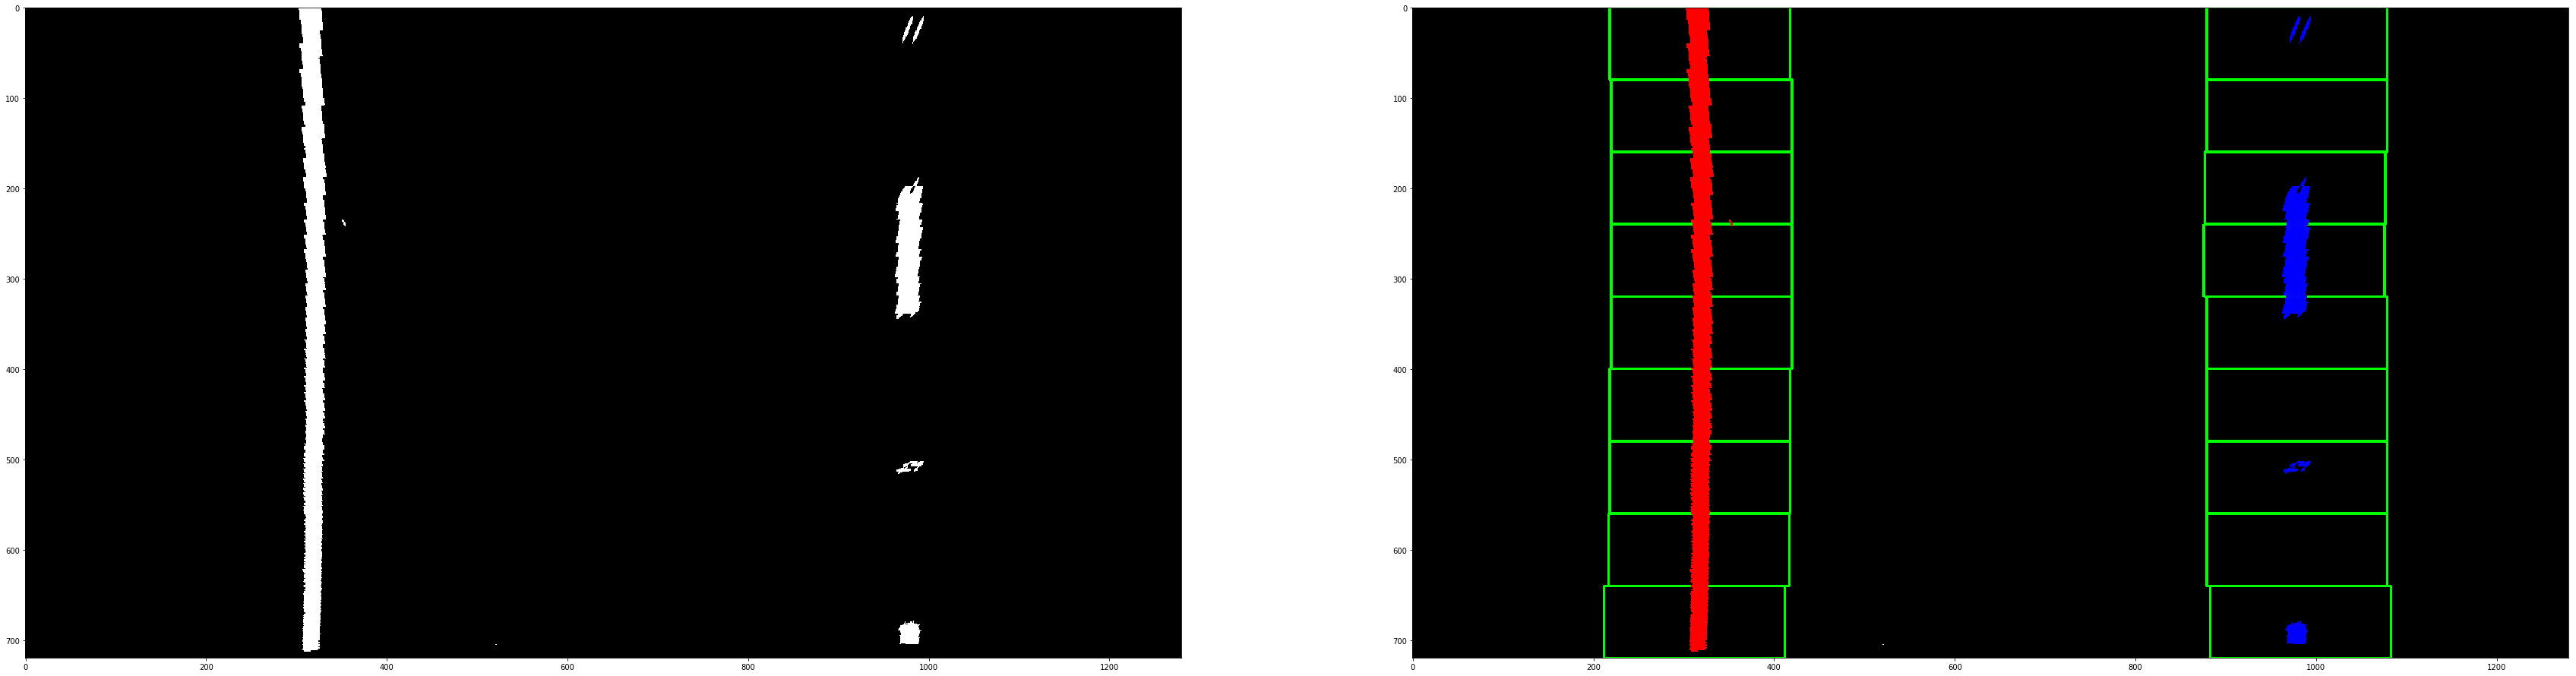

In [13]:
input_image = np.copy(warped)

# detect lanes per sliding windows search
lane_detector = LaneDetector(None, None, None)
leftx_prediction, rightx_prediction, window_image = lane_detector.sliding_windows_search(input_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(60,30))
ax1.imshow(input_image, cmap="gray")
ax2.imshow(window_image, cmap="gray")

# store image to output folder
cv2.imwrite('output_images/sliding_windows.jpg',window_image)

### Execute complete lane detection pipeline

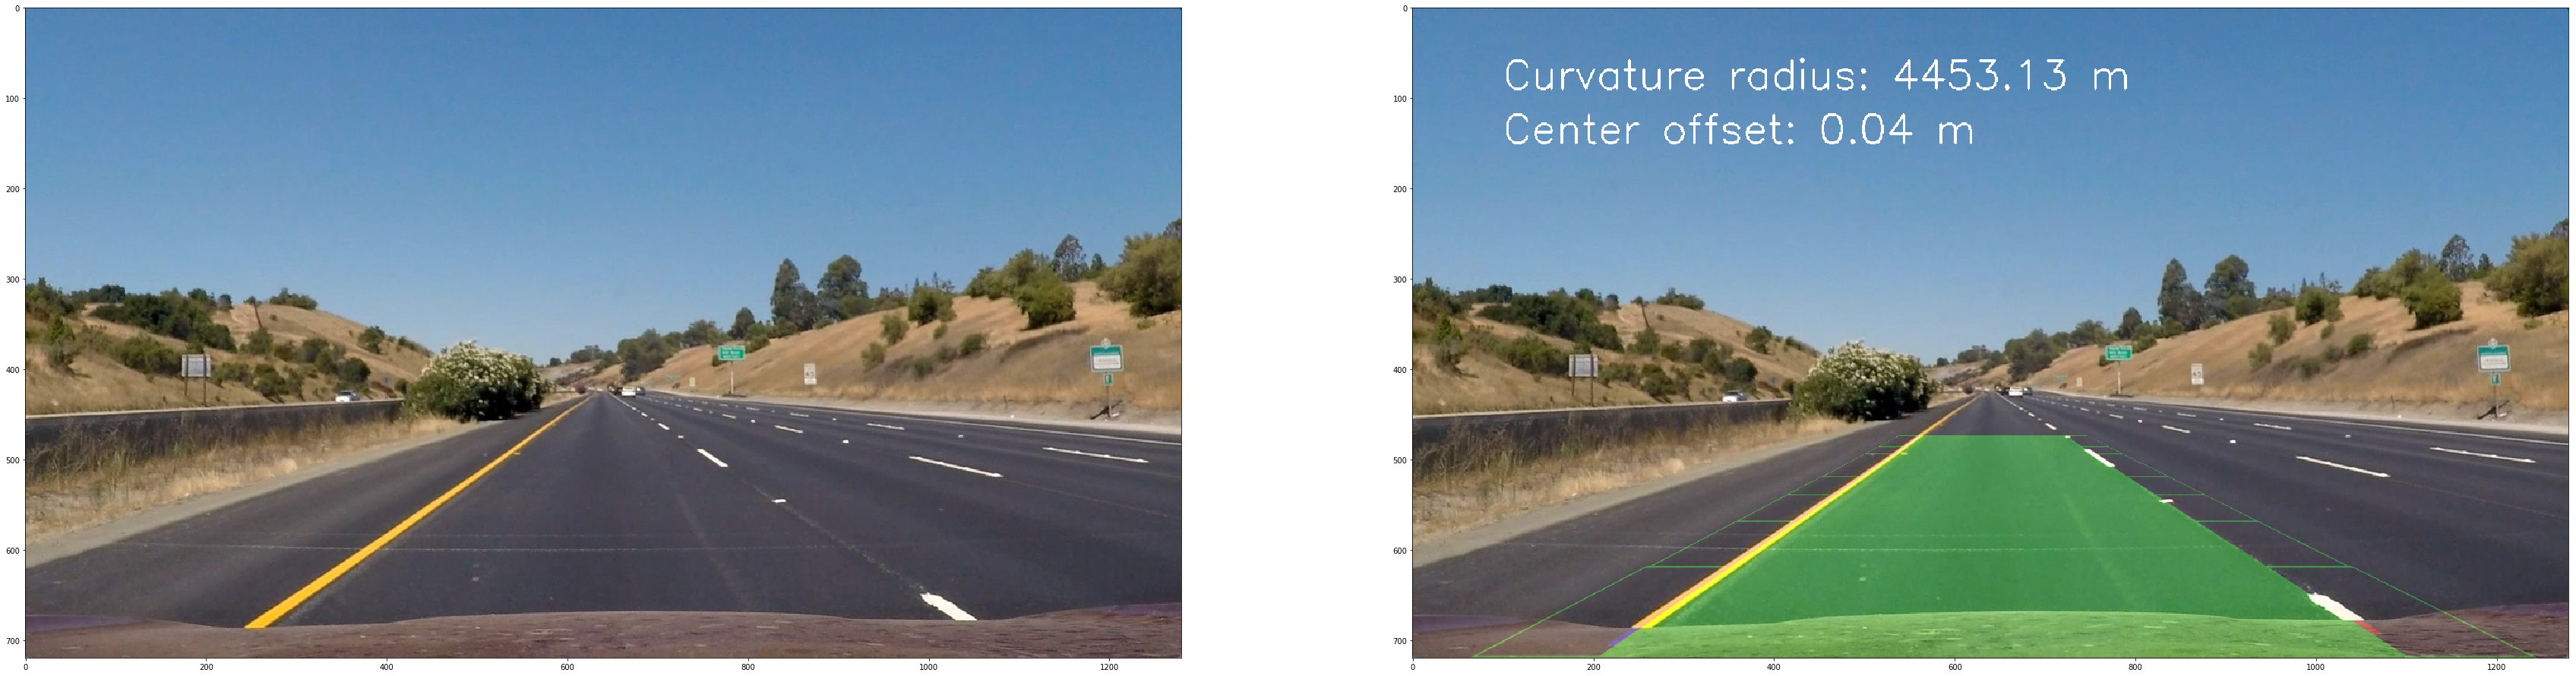

In [14]:
# initialize LandDetector
lane_detector = LaneDetector(camera_calibrate, color_grad_filter, image_transformer)

# Load input image
input_image = cv2.imread('test_images/straight_lines1.jpg')

# execute lane detection pipeline
output_image = cv2.cvtColor(lane_detector.pipeline(input_image), cv2.COLOR_BGR2RGB)

# show sample image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(60,30))
ax1.imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB), cmap="gray")
ax2.imshow(output_image, cmap="gray")

# store output image
plt.savefig('output_images/final.png')

In [15]:
lane_detector = LaneDetector(camera_calibrate, color_grad_filter, image_transformer)

# Execution method including color conversions for the video
def pipeline_execution(img):
    color_convert = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    out_img = lane_detector.pipeline(color_convert)
    return cv2.cvtColor(out_img, cv2.COLOR_RGB2BGR)

## Discussion

My biggest challenge was finding the right thresholds for the colors. In particular, in the challenge and harder challenge video, it is extremely difficult to detect the lane markings on the road, since they hardly stand out in places from the road with high solar radiation. To make the detection a bit more robust, I also used the R and G channels of the image.

Unfortunately, the pipeline failed on harder challenge video. The very sharp curves in combination with difficult lighting conditions have made the detection significantly more difficult. Maybe methods to increase the contrast could improve the recognition of the lines.

### Project Video

In [16]:
output = 'output_videos/project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip('project_video.mp4').subclip(0,5)
white_clip = clip1.fl_image(pipeline_execution)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video_output.mp4
[MoviePy] Writing video output_videos/project_video_output.mp4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1260/1261 [03:24<00:00,  6.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_output.mp4 

Wall time: 3min 25s


### Challenge Video

In [17]:
output = 'output_videos/challenge_video_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(pipeline_execution)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_videos/challenge_video_output.mp4
[MoviePy] Writing video output_videos/challenge_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 485/485 [01:18<00:00,  6.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video_output.mp4 

Wall time: 1min 19s


### Harder Challenge Video

In [18]:
output = 'output_videos/harder_challenge_video_output.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(pipeline_execution)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_videos/harder_challenge_video_output.mp4
[MoviePy] Writing video output_videos/harder_challenge_video_output.mp4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1199/1200 [03:48<00:00,  4.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/harder_challenge_video_output.mp4 

Wall time: 3min 50s
